In [1]:
# 1.加载所需模块
from sklearn import metrics             #Sklearn衡量模块
from sklearn import model_selection as ms     #Sklearn划分训练和测试模块
import matplotlib.pyplot as plt         #绘制表格模块
import random                           #随机数模块
import os
import numpy as np
import cv2                              #cv2模块

In [2]:
#2.创建HOG描述符，定义SVM训练函数、SVM准确率函数
#创建HOG描述符
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

#SVM训练函数
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

#SVM准确率函数
def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

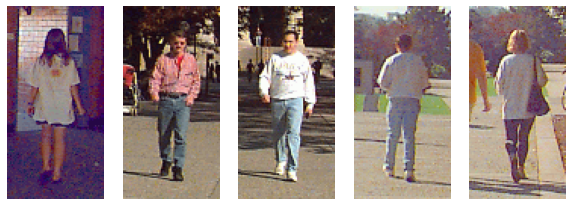

正例数据集的数据格式: (400, 1980)
正例数据集的结果格式: (400,)


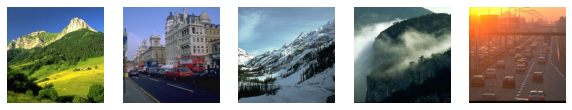

负例数据集的数据格式: (250, 1980)
负例数据集的结果格式: (250,)


In [3]:
# 3加载数据集函数，并查看数据的结构和内容
#3.1.获取正例数据集的数据和结果
datadir ='/home/retoo/Desktop/实验/数据集/2.机器学习/5-1 data/'
dataset = "pedestrians128x64"
extractdir = "%s/%s" % (datadir, dataset) #正例数据文件夹          
# 通过图像显示加载的数据信息
plt.figure(figsize=(10, 6))
for i in range(5):
    filename = "%s/per0010%d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()
# 将读取上来的图片转换为hog特征保存
random.seed(42)
X_pos = []
for i in random.sample(range(1,900), 400):
    filename = "%s/per%05d.ppm" % (extractdir, i)
    # 读取图片
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename)
        continue
    # 获取图片的HOG特征
    hog_img=hog.compute(img, (64, 64))
    # 将获得的HOG特征添加到数据集中
    X_pos.append(hog_img)
#正例数据集的数据和结果
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)
print("正例数据集的数据格式:",X_pos.shape)
print("正例数据集的结果格式:", y_pos.shape)

#3.2.获取负例的数据集的数据和结果
negset = "pedestrians_neg"
negdir = "%s/%s" % (datadir, negset)              #负例数据文件夹
filename_list = os.listdir(negdir)
# 通过图像显示加载的数据信息
plt.figure(figsize=(10, 6))
for i in range(5):
    filename = "%s//%s" % (negdir, filename_list[i])
    img = cv2.imread(filename)
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()
# 将读取上来的图片转换为hog特征保存
hroi = 128
wroi = 64
X_neg = []
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))
X_neg = np.array(X_neg, dtype=np.float32)
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)
print("负例数据集的数据格式:",X_neg.shape)
print("负例数据集的结果格式:", y_neg.shape)
# 3.3.将正例数据集和负例数据集合并
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

In [4]:
#4.将数据分为训练数据和测试数据
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42)
print('训练数据的特征信息的格式:',X_train.shape)
print('训练结果信息的格式:',y_train.shape)
print('测试数据的特征信息的格式:',X_test.shape)
print('测试结果信息的格式:',y_test.shape)

训练数据的特征信息的格式: (520, 1980)
训练结果信息的格式: (520,)
测试数据的特征信息的格式: (130, 1980)
测试结果信息的格式: (130,)


In [5]:
#5.SVM训练模型的训练
svm = train_svm(X_train, y_train)

In [6]:
#6.SVM训练模型的性能测试
#SVM训练模型在训练集上的准确率
score_train=score_svm(svm, X_train, y_train)
print('训练数据上的准确率:',score_train)
#SVM训练模型在测试集上的准确率
score_test=score_svm(svm, X_test, y_test)
print('测试数据上的准确率:',score_test)

训练数据上的准确率: 1.0
测试数据上的准确率: 0.6615384615384615


In [7]:
#7.模型自举
score_train = []
score_test = []
for j in range(3):
    # 7.1训练并评估模型
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
    #7.2从测试数据集中找到假正的图片
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
    if not np.any(false_pos):
        print('done')
        break
    #7.3=把假正的图片添加到训练数据集中，然后重复训练
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)
print('次训练数据上的准确率:',score_train)
print('次测试数据上的准确率:',score_test)

done
次训练数据上的准确率: [1.0, 1.0]
次测试数据上的准确率: [0.6615384615384615, 1.0]


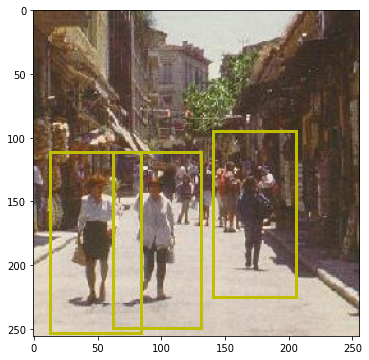

In [8]:
#8.更大图像中的行人检测
#8.1加载图片
img_test = cv2.imread('/home/retoo/Desktop/实验/数据集/2.机器学习/5-1 data/pedestrian_test.jpg')
stride = 16
found = []
for ystart in np.arange(0, img_test.shape[0], stride):
    for xstart in np.arange(0, img_test.shape[1], stride):
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue
        roi = img_test[ystart:ystart + hroi, xstart:xstart + wroi, :]
        feat = np.array([hog.compute(roi, (64, 64))])
        _, ypred = svm.predict(feat)
        if np.allclose(ypred, 1):
            found.append((ystart, xstart, hroi, wroi))

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
rho, _, _ = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()
hog.setSVMDetector(np.append(sv[0, :].ravel(), rho))

hogdef = cv2.HOGDescriptor()

hogdef.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

found, _ = hogdef.detectMultiScale(img_test)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
from matplotlib import patches
for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='y', linewidth=3, fill=False))
plt.show()